## 1.数据准备

#### 1.1 读取数据集

In [1]:
import numpy as np

data_filePath = '../resources/MNIST_data/mnist.npz'
data = np.load(data_filePath)
train_x, train_y = data['x_train'], data['y_train']
print(train_x.shape, train_y.shape)

(60000, 28, 28) (60000,)


#### 1.2 查看数据可视化的图片

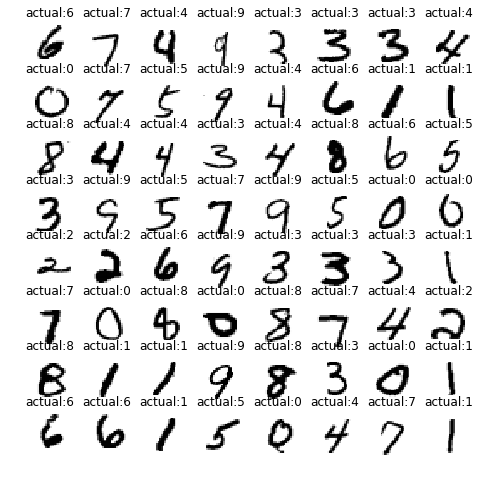

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np

def draw_digit(position, image, title):
    plt.subplot(*position)
    plt.imshow(image.reshape(-1, 28), cmap='gray_r')
    plt.axis('off')
    plt.title(title)
    
def batch_draw(batch_size):
    selected_indexes = np.random.choice(np.arange(60000), batch_size)
    images, labels = train_x[selected_indexes], train_y[selected_indexes]
    image_number = images.shape[0]
    row_number = math.ceil(image_number ** 0.5)
    column_number = row_number
    plt.figure(figsize=(row_number, column_number))
    for i in range(row_number):
        for j in range(column_number):
            index = i * column_number + j
            if index < image_number:
                position = (row_number, column_number, index+1)
                image = images[index]
                label = labels[index]
                title = 'actual:%d' %label
                draw_digit(position, image, title)

batch_draw(64)

## 2.搭建神经网络

In [3]:
import torch
import torch.nn as nn

class Net_1(nn.Module):
    def __init__(self):
        super(Net_1, self).__init__()
        self.linear_1 = nn.Linear(784, 10)
        
    def forward(self, x):
        x = torch.from_numpy(x.reshape(-1, 784)).float()
        y = self.linear_1(x)
        return y
    
    
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        self.linear_1 = nn.Linear(784, 300)
        self.linear_2 = nn.Linear(300, 10)
        
    def forward(self, x):
        x = torch.from_numpy(x.reshape(-1, 784)).float()
        x = self.linear_1(x).clamp(min=0)
        y = self.linear_2(x)
        return y

## 3.定义损失函数

In [4]:
loss_function = nn.CrossEntropyLoss()

## 4.在训练集上训练网络

In [5]:
import sys
# 实时更新进度条
def print_flush(print_string):
    print(print_string, end='\r')
    sys.stdout.flush()

In [6]:
net = Net_2()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
steps = 2000
batch_size = 100
index_1dArray = np.arange(60000)
for i in range(steps+1):
    batch_indexes = np.random.choice(index_1dArray, batch_size)
    # 前向传播
    batch_x = train_x[batch_indexes]
    predicted_Y = net(batch_x)
    # 计算损失值
    batch_y = train_y[batch_indexes]
    input_y = torch.from_numpy(batch_y).long()
    loss = loss_function(predicted_Y, input_y)
    loss_value = loss.item()
    # 计算准确率
    predicted_y = predicted_Y.argmax(axis=1)
    accuracy = (predicted_y==input_y).float().mean()
    accuracy_value = accuracy.item()
    # 每隔20步，打印训练记录
    if i % 20 == 0:
        print_flush('step:%d loss_value:%.6f accuracy_value:%.4f' %(
            i, loss_value, accuracy_value))
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## 5.模型测试

#### 5.1 模型评估

In [7]:
test_x, test_y = data['x_test'], data['y_test']
predicted_Y = net(test_x)
predicted_y = predicted_Y.argmax(axis=1).numpy()
accuracy = (test_y==predicted_y).astype('float').mean()
print(accuracy)

0.9502


#### 5.2 模型实用效果可视化

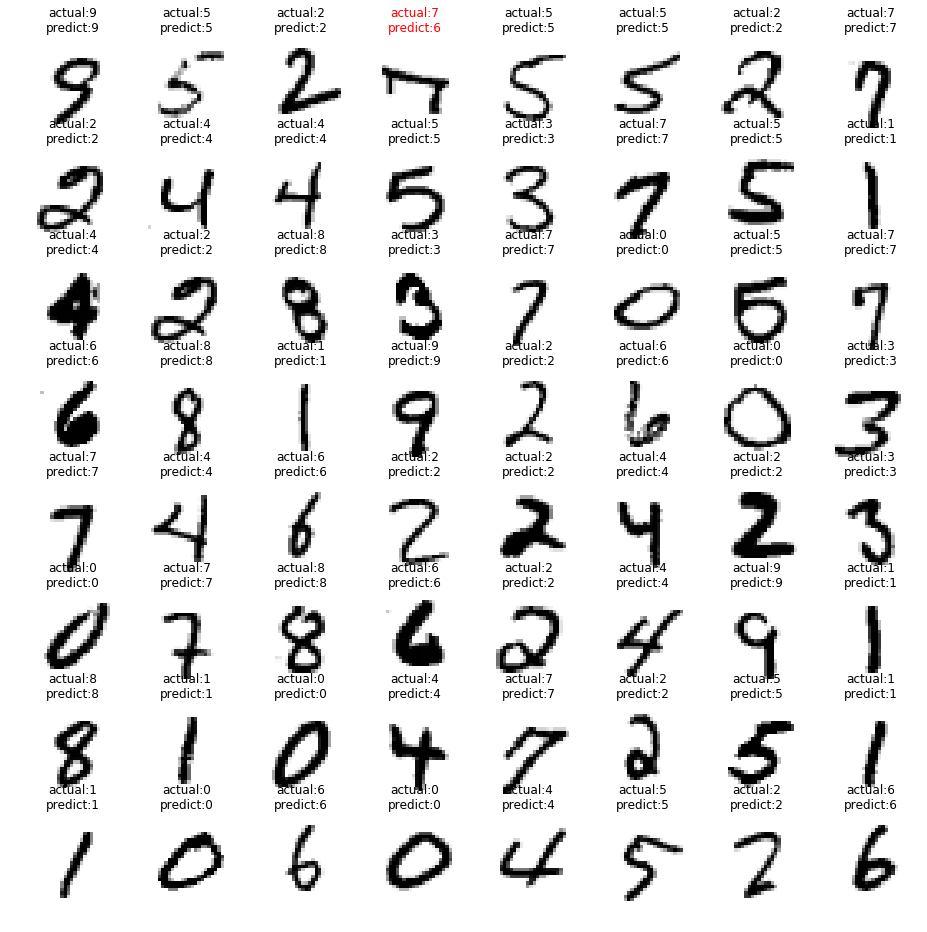

In [8]:
def draw_digit_2(position, image, title, isTrue):
    plt.subplot(*position)
    plt.imshow(image.reshape(-1, 28), cmap='gray_r')
    plt.axis('off')
    if not isTrue:
        plt.title(title, color='red')
    else:
        plt.title(title)
        
def batch_draw_2(batch_size):
    # 选出批量数据
    index_1dArray = np.arange(len(test_x))
    batch_indexes = np.random.choice(index_1dArray, batch_size)
    batch_x = test_x[batch_indexes]
    batch_y = test_y[batch_indexes]
    # 使用模型预测出结果
    predicted_y = net(batch_x).argmax(axis=1).numpy()
    # 规划画图行列数量
    image_number = batch_x.shape[0]
    row_number = math.ceil(image_number ** 0.5)
    column_number = row_number
    plt.figure(figsize=(row_number+8, column_number+8))
    # 循环遍历绘画每张子图
    for i in range(row_number):
        for j in range(column_number):
            index = i * column_number + j
            if index < image_number:
                position = (row_number, column_number, index+1)
                image = batch_x[index]
                actual = batch_y[index]
                predict = predicted_y[index]
                isTrue = actual==predict
                title = 'actual:%d\npredict:%d' %(actual,predict)
                draw_digit_2(position, image, title, isTrue)
                
batch_draw_2(64)                

## 6.卷积神经网络

#### 6.1 搭建神经网络

In [9]:
class Net_3(nn.Module):
    def __init__(self):
        super(Net_3, self).__init__()
        self.relu = nn.ReLU()
        self.bn_1 = nn.BatchNorm2d(1)
        self.conv_1 = nn.Conv2d(1, 32, (5,5), padding=1) # N * 28 * 28 * 32
        self.maxpool_1 = nn.MaxPool2d(2, 2, padding=1) # N * 14 * 14 * 32
        self.bn_2 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(32, 64, (5,5), padding=1) # N * 14 * 14 * 64
        self.maxpool_2 = nn.MaxPool2d(2, 2, padding=1) # N * 7 * 7 * 64
        self.flatten = nn.Flatten()
        self.bn_3 = nn.BatchNorm1d(7 * 7 * 64)
        self.linear_1 = nn.Linear(7 * 7 * 64, 128)
        self.bn_4 = nn.BatchNorm1d(128)
        self.linear_2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        # 第1层卷积
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.conv_1(x)
        x = self.maxpool_1(x)
        # 第2层卷积
        x = self.bn_2(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.maxpool_2(x)
        # 2维矩阵展平为1维矩阵
        x = self.flatten(x)
        # 第1层全连接
        x = self.bn_3(x)
        x = self.relu(x)
        x = self.linear_1(x)
        # 第2层全连接
        x = self.bn_4(x)
        x = self.relu(x)
        y = self.linear_2(x)
        return y

#### 6.2 在训练集上训练网络

In [10]:
net = Net_3()
device = torch.device('cuda')
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
steps = 2000
batch_size = 200
index_1dArray = np.arange(60000)
tensor_x = torch.from_numpy(train_x.reshape(-1, 28, 28, 1)).float()
tensor_y = torch.from_numpy(train_y).long()
for i in range(steps+1):
    batch_indexes = np.random.choice(index_1dArray, batch_size)
    # 前向传播
    batch_x = tensor_x[batch_indexes]
    input_x = batch_x.to(device)
    predicted_Y = net(input_x)
    # 计算损失值
    batch_y = tensor_y[batch_indexes]
    input_y = batch_y.to(device)
    loss = loss_function(predicted_Y, input_y)
    loss_value = loss.item()
    # 计算准确率
    predicted_y = predicted_Y.argmax(axis=1)
    accuracy = (predicted_y==input_y).float().mean()
    accuracy_value = accuracy.item()
    # 每隔20步，打印训练记录
    if i % 20 == 0:
        print_flush('step:%d loss_value:%.6f accuracy_value:%.4f' %(
            i, loss_value, accuracy_value))
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#### 6.3 模型评估

In [11]:
test_x, test_y = data['x_test'], data['y_test']
predicted_y = np.zeros((len(test_y),))
for i in range(0, len(test_x), batch_size):
    start_index = i
    end_index = i + batch_size
    x = test_x[start_index: end_index]
    input_x = torch.from_numpy(x.reshape(-1, 28, 28, 1)).float()
    input_x = input_x.to(device)
    predicted_Y = net(input_x)
    predicted_y[start_index:end_index] = predicted_Y.argmax(axis=1).cpu().numpy()
accuracy = (test_y==predicted_y).astype('float').mean()
print(accuracy)

0.9914
